In [1]:
import pandas as pd

In [2]:
BTC_15 = pd.read_csv("data/data/ohlcv/BTCUSDT_15m_20170208_20250830.csv")
ETH_15 = pd.read_csv("data/data/ohlcv/ETHUSDT_15m_20170208_20250830.csv")

In [9]:
df = BTC_15.copy()
df = df[df["timestamp"] >= "2025-05-03"]

In [10]:
# Calculate the split index
split_idx = int(len(df) * 1)  # first 60% train, last 40% test

# Split into train/test
train = df.iloc[:split_idx]
test  = df.iloc[split_idx:]

print("Train size:", len(train))
print("Test size:", len(test))

Train size: 11473
Test size: 0


In [11]:
from Trading_algos.strategy_tester import StrategyTester

In [12]:
tester = StrategyTester(initial_capital=10000)

In [15]:
results = tester.run_backtest(
                            'FibonacciChannelStrategy',
                            train,
                            timeframe="15m",
                            sensitivity=18,
                            leverage=1.0,
                            sl_percent=0,         # 1% adjustment to fib levels
                            fixed_stop=False,       # Use fib_786 (long) / fib_236 (short)
                            break_even_after_tp=1,  # Move to breakeven after TP2 hit
                            use_take_profits=True,
                            tp1_pct=1, tp1_close=40.0,
                            tp2_pct=2, tp2_close=30.0,
                            tp3_pct=3, tp3_close=20.0,
                            tp4_pct=4, tp4_close=10.0,
                            # Risk
                            risk_per_trade=0.015,   # 1.5% risk per trade
                            verbose=True
                        )

Starting backtest for FibonacciChannelStrategy
Data period: 2025-05-03 00:00:00+00:00 to 2025-08-30 12:00:00+00:00
Data points: 11473
Generating trading signals...
Signals — long: 29 short: 30
First long idx: [364, 1038, 1221] First short idx: [184, 921, 1164]
Running backtest simulation...


Backtesting: 100%|████████████████| 11473/11473 [00:06<00:00, 1663.84bars/s, Trades=48, Capital=$11,294, Position=FLAT]

Calculating performance metrics...

🎯 BACKTEST COMPLETED SUCCESSFULLY!
   Strategy: FibonacciChannelStrategy
   Total Trades: 48
   Final Return: 12.94%
   Final Capital: $11,293.67
   Win Rate: 72.92%
   Profit Factor: 2.41
   Max Drawdown: 4.99%
   Sharpe Ratio: 3.574
   Risk:Reward: 0.90
   Market Exposure: 50.92%
   Total Fees: $599.24

💡 Use display_comprehensive_metrics('FibonacciChannelStrategy') for detailed analysis


C:\Users\gulle\Documents\Trading\Trading_algos\strategy_tester.py:344: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  plot_timestamps = pd.to_datetime(data['timestamp']).dt.to_pydatetime()



📊 COMPREHENSIVE METRICS TABLE FOR FIBONACCICHANNELSTRATEGY

PERFORMANCE:
--------------------------------------------------
  Total Return        : 13.69%
  Final Capital       : $11,368.62
  Total Trades        : 55
  Win Rate            : 69.09%
  Profit Factor       : 2.19
  Risk:Reward         : 0.98

RISK METRICS:
--------------------------------------------------
  Max Drawdown        : 8.45%
  Sharpe Ratio        : 2.915
  Sortino Ratio       : 2.903
  Calmar Ratio        : 10.148
  Volatility          : 29.43%
  VaR (95%)           : -0.15%

TRADE ANALYSIS:
--------------------------------------------------
  Avg Win             : $125.99
  Avg Loss            : $128.60
  Largest Win         : $708.67
  Largest Loss        : $-161.29
  Max Consec Losses   : 2
  Max Consec Wins     : 7

STRATEGY BEHAVIOR:
--------------------------------------------------
  Trades/Day          : 0.47
  Avg Hold Time       : 25.37h
  Market Exposure     : 49.86%
  Break-even          : 9.25%
  T

C:\Users\gulle\Documents\Trading\Trading_algos\strategy_tester.py:390: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  plot_timestamps_equity = pd.to_datetime(timestamps).dt.to_pydatetime()


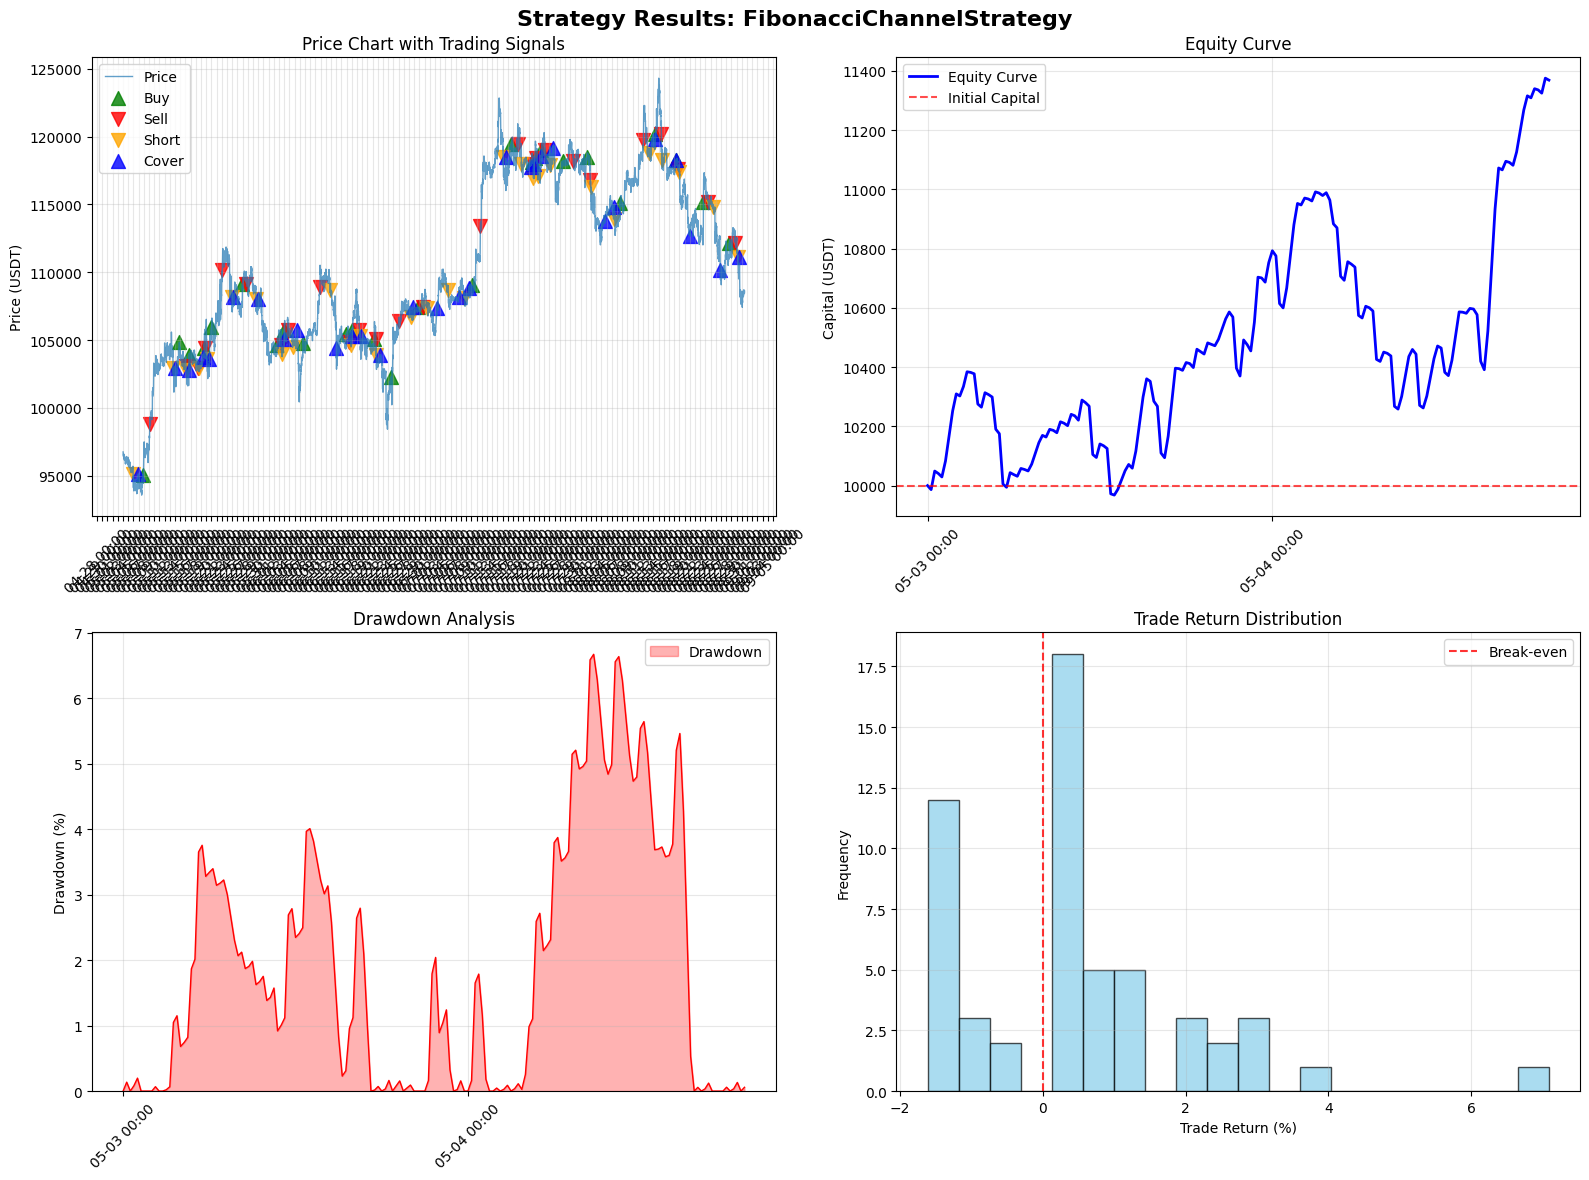

In [14]:
# Cell 4: View detailed metrics
tester.display_comprehensive_metrics('FibonacciChannelStrategy')

# Cell 5: Plot results
tester.plot_results('FibonacciChannelStrategy',show_plot=True)